In [1]:
'''
• What channel is driving the most cost-effective reach?
• What channel is driving the most site traffic?
• What channel is most effective at driving new customers?
• Did local radio have an impact?
'''

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

In [3]:
path = "/Users/kenny/Documents/Analyst Assessment IPG Health.xlsx"

In [4]:
df1 = pd.read_excel(path, sheet_name = "Dataset1")
df2 = pd.read_excel(path, sheet_name = "Dataset2")

In [5]:
df1.head()
df2.head()

,date,Channel,site visits,time on site mins,bounce rate,new customers
0,2022-09-05,AFF,236,4.305,0.69,227
1,2022-09-10,AFF,200,2.970,0.73,167
2,2022-09-15,AFF,216,4.155,0.71,198
3,2022-09-20,AFF,168,2.610,0.75,148
4,2022-09-25,AFF,160,2.265,0.67,134


In [6]:
df1.columns = ["Date", "Channel", "Spend", "Impressions", "Clicks"]
df2.columns = ["Date", "Channel", "Site_Visits", "Time_On_Site_Mins", "Bounce_Rate", "New_Customers"]

In [7]:
df1["Date"] = pd.to_datetime(df1["Date"])
df2["Date"] = pd.to_datetime(df2["Date"])

In [8]:
df1.head()
#df2.head()

,Date,Channel,Spend,Impressions,Clicks
0,2022-09-01,AFF,1400.0,28000,45.0
1,2022-09-02,AFF,2100.0,42000,67.0
2,2022-09-03,AFF,1900.0,38000,61.0
3,2022-09-04,AFF,2600.0,52000,83.0
4,2022-09-05,AFF,2350.0,47000,75.0


In [9]:
merged_df = pd.merge(df1, df2, on=["Date", "Channel"], how="outer")
merged_df.head()

,Date,Channel,Spend,Impressions,Clicks,Site_Visits,Time_On_Site_Mins,Bounce_Rate,New_Customers
0,2022-09-01,AFF,1400.0,28000,45.0,NaN,NaN,NaN,NaN
1,2022-09-02,AFF,2100.0,42000,67.0,NaN,NaN,NaN,NaN
2,2022-09-03,AFF,1900.0,38000,61.0,NaN,NaN,NaN,NaN
3,2022-09-04,AFF,2600.0,52000,83.0,NaN,NaN,NaN,NaN
4,2022-09-05,AFF,2350.0,47000,75.0,236.0,4.305,0.69,227.0


In [10]:
merged_df = merged_df.sort_values(["Channel", "Date"]).reset_index(drop=True)
merged_df["Day_of_Week"] = merged_df["Date"].dt.day_name()

In [11]:
merged_df.head()

,Date,Channel,Spend,Impressions,Clicks,Site_Visits,Time_On_Site_Mins,Bounce_Rate,New_Customers,Day_of_Week
0,2022-09-01,AFF,1400.0,28000,45.0,NaN,NaN,NaN,NaN,Thursday
1,2022-09-02,AFF,2100.0,42000,67.0,NaN,NaN,NaN,NaN,Friday
2,2022-09-03,AFF,1900.0,38000,61.0,NaN,NaN,NaN,NaN,Saturday
3,2022-09-04,AFF,2600.0,52000,83.0,NaN,NaN,NaN,NaN,Sunday
4,2022-09-05,AFF,2350.0,47000,75.0,236.0,4.305,0.69,227.0,Monday


In [12]:
# Engagement metric
merged_df["Engaged_Minutes"] = merged_df["Site_Visits"] * merged_df["Time_On_Site_Mins"]

# Lag variables (t-1)
merged_df["Clicks_Lag1"] = merged_df.groupby("Channel")["Clicks"].shift(1)
merged_df["Impressions_Lag1"] = merged_df.groupby("Channel")["Impressions"].shift(1)

In [13]:
# Drop rows with missing values in any relevant column
df_clean = merged_df.dropna(subset=["Clicks", "Impressions", "Site_Visits"])

# Pearson correlations
corr_clicks, _ = pearsonr(df_clean["Clicks"], df_clean["Site_Visits"])
corr_impressions, _ = pearsonr(df_clean["Impressions"], df_clean["Site_Visits"])

# Partial correlation (site_visits ~ impressions controlling clicks)
model_partial = sm.OLS(df_clean["Site_Visits"], sm.add_constant(df_clean[["Impressions", "Clicks"]])).fit()
partial_corr_impr = model_partial.params["Impressions"]

print("Correlation (Clicks vs Site_Visits):", corr_clicks)
print("Correlation (Impressions vs Site_Visits):", corr_impressions)
print("Partial correlation (Impressions controlling Clicks):", partial_corr_impr)

Correlation (Clicks vs Site_Visits): 0.5516485974903543
Correlation (Impressions vs Site_Visits): 0.6218849233962866
Partial correlation (Impressions controlling Clicks): 0.0023874600375878427


In [14]:
fe_model = smf.ols("Site_Visits ~ Clicks + Impressions + C(Channel) + C(Day_of_Week)", data=merged_df).fit(cov_type="HC3")

In [15]:
merged_df["log_visits"] = np.log1p(merged_df["Site_Visits"])
merged_df["log_clicks"] = np.log1p(merged_df["Clicks"])
merged_df["log_impressions"] = np.log1p(merged_df["Impressions"])

elas_model = smf.ols("log_visits ~ log_clicks + log_impressions", data=merged_df).fit(cov_type="HC3")

In [16]:
med_step1 = smf.ols("Clicks ~ Impressions", data=merged_df).fit()
med_step2 = smf.ols("Site_Visits ~ Impressions", data=merged_df).fit()
med_step3 = smf.ols("Site_Visits ~ Impressions + Clicks", data=merged_df).fit()

In [17]:
merged_df["minutes_per_dollar"] = merged_df["Engaged_Minutes"] / merged_df["Spend"].replace(0, np.nan)
channel_efficiency = merged_df.groupby("Channel")[["Engaged_Minutes", "minutes_per_dollar"]].mean()

In [18]:
df_nonnull = merged_df.dropna(subset=["Clicks", "Site_Visits"])
df_nonnull["click_bin"] = pd.qcut(df_nonnull["Clicks"], 5, duplicates="drop")
diminishing = df_nonnull.groupby("click_bin")["Site_Visits"].mean()

<ipython-input-18-a40d13241ec6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonnull["click_bin"] = pd.qcut(df_nonnull["Clicks"], 5, duplicates="drop")


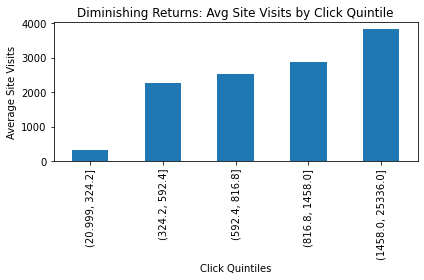

In [19]:
plt.figure(figsize=(6,4))
diminishing.plot(kind="bar")
plt.title("Diminishing Returns: Avg Site Visits by Click Quintile")
plt.ylabel("Average Site Visits")
plt.xlabel("Click Quintiles")
plt.tight_layout()
plt.show()

In [20]:
lag_model = smf.ols("Site_Visits ~ Clicks_Lag1 + Impressions_Lag1", data=merged_df).fit(cov_type="HC3")

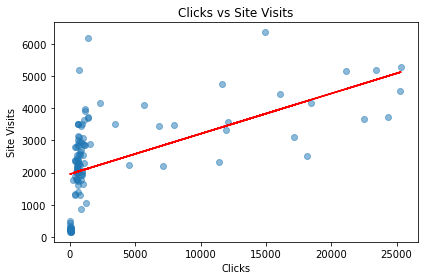

In [21]:
plt.figure(figsize=(6,4))
plt.scatter(df_clean["Clicks"], df_clean["Site_Visits"], alpha=0.5)
m, b = np.polyfit(df_clean["Clicks"], df_clean["Site_Visits"], 1)
plt.plot(df_clean["Clicks"], m*df_clean["Clicks"]+b, color="red")
plt.title("Clicks vs Site Visits")
plt.xlabel("Clicks")
plt.ylabel("Site Visits")
plt.tight_layout()
plt.show()

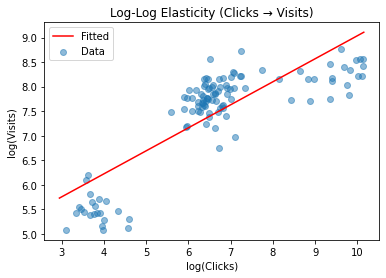

In [22]:
# Refit model to ensure it's only Clicks to Visits
elas_model = smf.ols("log_visits ~ log_clicks", data=merged_df).fit()

plt.figure(figsize=(6,4))
plt.scatter(merged_df["log_clicks"], merged_df["log_visits"], alpha=0.5, label="Data")

# Prepare prediction DataFrame for smooth fitted line
x_sorted = np.sort(merged_df["log_clicks"].dropna())
pred_df = pd.DataFrame({"log_clicks": x_sorted})
y_pred = elas_model.predict(pred_df)

plt.plot(x_sorted, y_pred, color="red", label="Fitted")

plt.title("Log-Log Elasticity (Clicks → Visits)")
plt.xlabel("log(Clicks)")
plt.ylabel("log(Visits)")
plt.legend()
plt.show()


In [23]:
merged_df.head()

,Date,Channel,Spend,Impressions,Clicks,Site_Visits,Time_On_Site_Mins,Bounce_Rate,New_Customers,Day_of_Week,Engaged_Minutes,Clicks_Lag1,Impressions_Lag1,log_visits,log_clicks,log_impressions,minutes_per_dollar
0,2022-09-01,AFF,1400.0,28000,45.0,NaN,NaN,NaN,NaN,Thursday,NaN,NaN,NaN,NaN,3.828641,10.239996,NaN
1,2022-09-02,AFF,2100.0,42000,67.0,NaN,NaN,NaN,NaN,Friday,NaN,45.0,28000.0,NaN,4.219508,10.645449,NaN
2,2022-09-03,AFF,1900.0,38000,61.0,NaN,NaN,NaN,NaN,Saturday,NaN,67.0,42000.0,NaN,4.127134,10.545368,NaN
3,2022-09-04,AFF,2600.0,52000,83.0,NaN,NaN,NaN,NaN,Sunday,NaN,61.0,38000.0,NaN,4.430817,10.859018,NaN
4,2022-09-05,AFF,2350.0,47000,75.0,236.0,4.305,0.69,227.0,Monday,1015.98,83.0,52000.0,5.46806,4.330733,10.757924,0.432332


In [24]:
agg_df1 = df1.groupby("Channel").agg(
    spend=("Spend", "sum"),
    impressions=("Impressions", "sum"),
    clicks=("Clicks", "sum")
).reset_index()

In [25]:
agg_df2 = df2.groupby("Channel").agg(
    site_visits=("Site_Visits", "sum"),
    time_on_site_mins=("Time_On_Site_Mins", "sum"),
    new_customers=("New_Customers", "sum"),
).reset_index()

In [26]:
agg_df1.head()

,Channel,spend,impressions,clicks
0,AFF,273050.00,5461000,5260.0
1,CTV,1290647.66,38705000,73044.0
2,Display,1016258.00,6379164,91307.0
3,Local Radio,0.00,27500000,0.0
4,Search,1193010.00,95774844,1563259.0


In [27]:
agg_df2.head()

,Channel,site_visits,time_on_site_mins,new_customers
0,AFF,5548,80.82,5391
1,CTV,59965,54.91,4845
2,Display,58493,50.99,5548
3,Search,89187,57.58,6610
4,Social,55347,50.09,6091


In [28]:
w_bounce = df2.assign(weight=df2["Site_Visits"]).groupby("Channel").apply(
    lambda g: np.average(g["Bounce_Rate"], weights=g["Site_Visits"]) if g["Site_Visits"].sum() > 0 else np.nan
).reset_index(name="Bounce_Rate_Weighted")

In [29]:
channel_summary = (
    agg_df1
    .merge(agg_df2, on="Channel", how="left")
    .merge(w_bounce, on="Channel", how="left")
)

In [30]:
channel_summary["cpm"] = channel_summary["spend"] / (channel_summary["impressions"] / 1000)
channel_summary["ctr"] = channel_summary["clicks"] / channel_summary["impressions"]
channel_summary["conversion_rate"] = channel_summary["new_customers"] / channel_summary["site_visits"]
channel_summary["cac"] = channel_summary["spend"] / channel_summary["new_customers"]

In [31]:
print("\n=== Channel Summary ===")
print(channel_summary)


=== Channel Summary ===
       Channel       spend  impressions     clicks  site_visits  \
0          AFF   273050.00      5461000     5260.0       5548.0   
1          CTV  1290647.66     38705000    73044.0      59965.0   
2      Display  1016258.00      6379164    91307.0      58493.0   
3  Local Radio        0.00     27500000        0.0          NaN   
4       Search  1193010.00     95774844  1563259.0      89187.0   
5       Social   621294.00      7559047    86617.0      55347.0   

   time_on_site_mins  new_customers  Bounce_Rate_Weighted         cpm  \
0              80.82         5391.0              0.625516   50.000000   
1              54.91         4845.0              0.593596   33.345760   
2              50.99         5548.0              0.900733  159.308963   
3                NaN            NaN                   NaN    0.000000   
4              57.58         6610.0              0.601446   12.456402   
5              50.09         6091.0              0.602547   82.1921

In [32]:
# EDA Visualizations

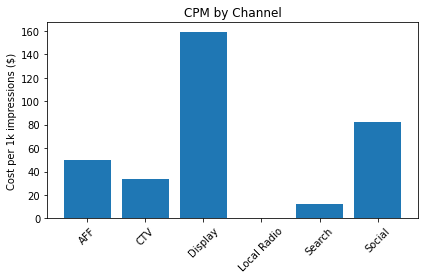

In [33]:
# Cost per 1k impressions
plt.figure()
plt.bar(channel_summary["Channel"], channel_summary["cpm"])
plt.title("CPM by Channel")
plt.ylabel("Cost per 1k impressions ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

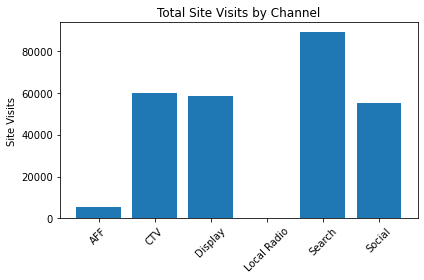

In [34]:
# Site visits
plt.figure()
plt.bar(channel_summary["Channel"], channel_summary["site_visits"])
plt.title("Total Site Visits by Channel")
plt.ylabel("Site Visits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

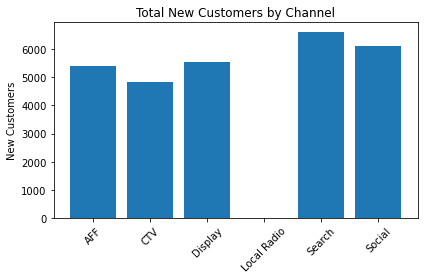

In [35]:
# New customers
plt.figure()
plt.bar(channel_summary["Channel"], channel_summary["new_customers"])
plt.title("Total New Customers by Channel")
plt.ylabel("New Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

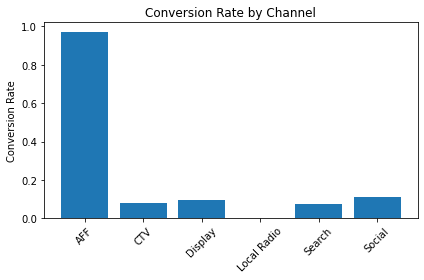

In [36]:
# Conversion rate
plt.figure()
plt.bar(channel_summary["Channel"], channel_summary["conversion_rate"])
plt.title("Conversion Rate by Channel")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

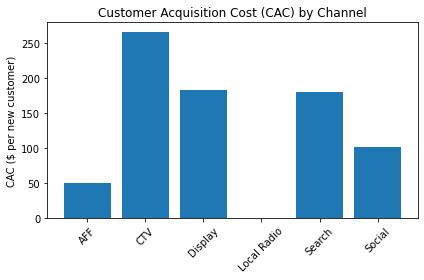

In [37]:
# CAC
plt.figure()
plt.bar(channel_summary["Channel"], channel_summary["cac"])
plt.title("Customer Acquisition Cost (CAC) by Channel")
plt.ylabel("CAC ($ per new customer)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Local Radio Impact

In [39]:
# Daily-level data
digital = df1[df1["Channel"] != "Local Radio"]
lr = df1[df1["Channel"] == "Local Radio"]

daily_digital = digital.groupby("Date").agg(
    digital_spend=("Spend", "sum"),
    digital_impressions=("Impressions", "sum"),
    digital_clicks=("Clicks", "sum")
).reset_index()

daily_lr = lr.groupby("Date").agg(
    lr_impressions=("Impressions", "sum")
).reset_index()

daily_traffic = df2.groupby("Date").agg(
    site_visits=("Site_Visits", "sum"),
    new_customers=("New_Customers", "sum")
).reset_index()

daily = daily_traffic.merge(daily_digital, on="Date", how="left").merge(daily_lr, on="Date", how="left")
daily["lr_active"] = (daily["lr_impressions"].fillna(0) > 0).astype(int)

In [40]:
# Compare averages
means_with_lr = daily.loc[daily["lr_active"] == 1, ["site_visits", "new_customers"]].mean()
means_without_lr = daily.loc[daily["lr_active"] == 0, ["site_visits", "new_customers"]].mean()
lift = (means_with_lr - means_without_lr) / means_without_lr

In [41]:
print("\n=== Local Radio Simple Comparison ===")
print("With LR:", means_with_lr)
print("Without LR:", means_without_lr)
print("Lift (%):", lift)


=== Local Radio Simple Comparison ===
With LR: site_visits      3410.35
new_customers     371.15
dtype: float64
Without LR: site_visits      2131.202128
new_customers     224.063830
dtype: float64
Lift (%): site_visits      0.600200
new_customers    0.656448
dtype: float64


In [42]:
# Regression Analysis

In [43]:
# OLS regression helper
def ols(y,X):
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    n, k = X.shape
    residuals = y - X @ beta
    s2 = (residuals @ residuals) / (n-k)
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(s2 * XtX_inv))
    return beta, se

In [44]:
daily.head()

,Date,site_visits,new_customers,digital_spend,digital_impressions,digital_clicks,lr_impressions,lr_active
0,2022-09-01,1611,101,32287.90,1380633,18092.0,0,0
1,2022-09-02,3578,300,28770.33,1118200,13998.0,0,0
2,2022-09-03,2403,465,26290.94,957639,12533.0,0,0
3,2022-09-04,3140,242,39405.78,1189379,15821.0,0,0
4,2022-09-05,236,227,33711.98,1391402,17065.0,0,0


In [45]:
y1 = daily["site_visits"].values
y2 = daily["new_customers"].values

In [46]:
# Model 1: binary LR active
X1 = np.column_stack([np.ones(len(daily)), daily["digital_spend"].fillna(0).values, daily["lr_active"].values])
beta1, se1 = ols(y1, X1)
beta2, se2 = ols(y2, X1)

print("\n=== OLS with LR Active (binary) ===")
print("Site visits effect of LR:", beta1[2], "±", 1.96*se1[2])
print("New customers effect of LR:", beta2[2], "±", 1.96*se2[2])


=== OLS with LR Active (binary) ===
Site visits effect of LR: 1023.2210153010008 ± 865.2650449256773
New customers effect of LR: 95.65471960952857 ± 51.13201738763895


In [47]:
# Model 2: LR impressions (per million)
lr_impressions_m = daily["lr_impressions"].fillna(0).values / 1_000_000
X2 = np.column_stack([np.ones(len(daily)), daily["digital_spend"].fillna(0).values, lr_impressions_m])
beta1b, se1b = ols(y1, X2)
beta2b, se2b = ols(y2, X2)

print("\n=== OLS with LR Impressions ===")
print("Per +1M LR impressions -> site visits:", beta1b[2], "±", 1.96*se1b[2])
print("Per +1M LR impressions -> new customers:", beta2b[2], "±", 1.96*se2b[2])


=== OLS with LR Impressions ===
Per +1M LR impressions -> site visits: 623.9912768801198 ± 557.6172313383225
Per +1M LR impressions -> new customers: 61.2071684873223 ± 32.89086432567856


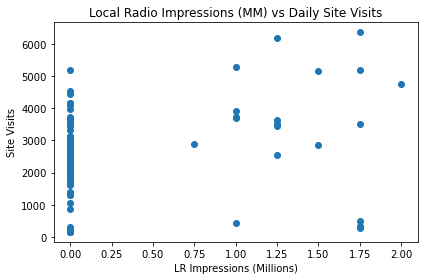

In [48]:
# Scatterplot: LR impressions vs site visits
plt.figure()
plt.scatter(lr_impressions_m, daily["site_visits"])
plt.title("Local Radio Impressions (MM) vs Daily Site Visits")
plt.xlabel("LR Impressions (Millions)")
plt.ylabel("Site Visits")
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

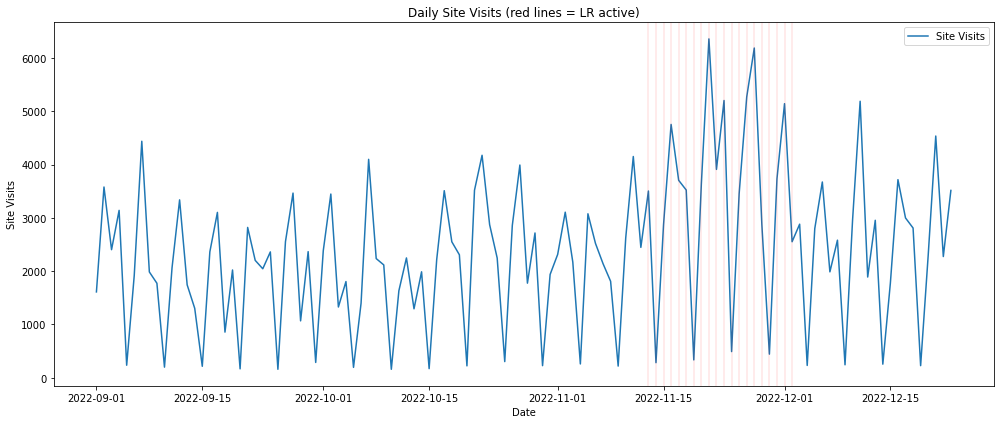

In [49]:
# Time series: site visits with LR active highlighted
plt.figure()
fig, ax = plt.subplots(figsize=(14,6))
plt.plot(daily["Date"], daily["site_visits"], label="Site Visits")
for x, active in zip(daily["Date"], daily["lr_active"]):
    if active:
        plt.axvline(x=x, color="red", alpha=0.1)
plt.title("Daily Site Visits (red lines = LR active)")
plt.xlabel("Date")
plt.ylabel("Site Visits")
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# Ensure 'Date' is a column
if 'Date' not in merged_df.columns:
    merged_df = merged_df.reset_index()  # bring back Date if previously index

# Strip column name if needed
merged_df.rename(columns=lambda x: x.strip(), inplace=True)

# Set Date as index
merged_df.set_index("Date", inplace=True)

# Define periods
rolling_periods = ["W","M"]  # Weekly, Monthly

rolling_metrics = {}
for period in rolling_periods:
    rolling_metrics[period] = merged_df.groupby("Channel").resample(period).agg({
        "Spend":"sum",
        "Site_Visits":"sum",
        "New_Customers":"sum",
        "Engaged_Minutes":"sum",
        "Clicks":"sum",
        "Impressions":"sum"
    }).reset_index()
    
    # Additional metrics
    rolling_metrics[period]["minutes_per_dollar"] = rolling_metrics[period]["Engaged_Minutes"] / rolling_metrics[period]["Spend"].replace(0,np.nan)
    rolling_metrics[period]["conversion_rate"] = rolling_metrics[period]["New_Customers"] / rolling_metrics[period]["Site_Visits"].replace(0,np.nan)
    rolling_metrics[period]["ctr"] = rolling_metrics[period]["Clicks"] / rolling_metrics[period]["Impressions"].replace(0,np.nan)
    rolling_metrics[period]["cac"] = rolling_metrics[period]["Spend"] / rolling_metrics[period]["New_Customers"].replace(0,np.nan)
    rolling_metrics[period]["cost_per_visit"] = rolling_metrics[period]["Spend"] / rolling_metrics[period]["Site_Visits"].replace(0,np.nan)
    rolling_metrics[period]["avg_time_per_visit"] = rolling_metrics[period]["Engaged_Minutes"] / rolling_metrics[period]["Site_Visits"].replace(0,np.nan)
    rolling_metrics[period]["clicks_per_visit"] = rolling_metrics[period]["Clicks"] / rolling_metrics[period]["Site_Visits"].replace(0,np.nan)

# Example: Display weekly rolling metrics
rolling_metrics['W'].head()


,Channel,Date,Spend,Site_Visits,New_Customers,Engaged_Minutes,Clicks,Impressions,minutes_per_dollar,conversion_rate,ctr,cac,cost_per_visit,avg_time_per_visit,clicks_per_visit
0,AFF,2022-09-04,8000.0,0.0,0.0,0.00,256.0,160000,0.000000,NaN,0.001600,NaN,NaN,NaN,NaN
1,AFF,2022-09-11,13250.0,436.0,394.0,1609.98,425.0,265000,0.121508,0.903670,0.001604,33.629442,30.389908,3.692615,0.974771
2,AFF,2022-09-18,14750.0,216.0,198.0,897.48,471.0,295000,0.060846,0.916667,0.001597,74.494949,68.287037,4.155000,2.180556
3,AFF,2022-09-25,11150.0,328.0,282.0,800.88,357.0,223000,0.071828,0.859756,0.001601,39.539007,33.993902,2.441707,1.088415
4,AFF,2022-10-02,15750.0,288.0,231.0,1507.68,436.0,315000,0.095726,0.802083,0.001384,68.181818,54.687500,5.235000,1.513889


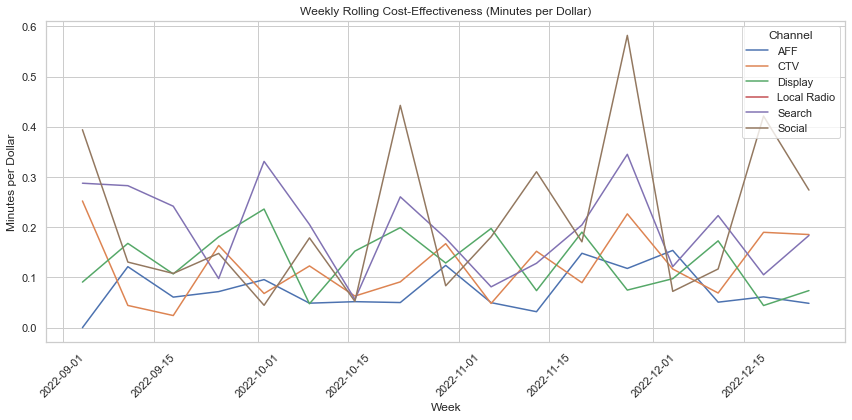

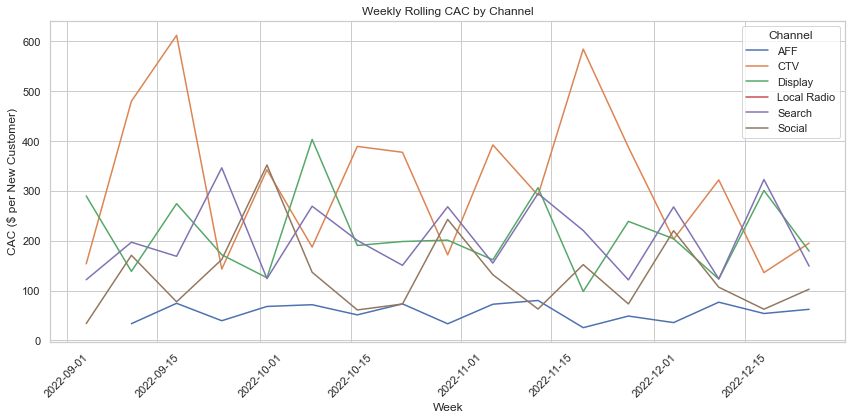

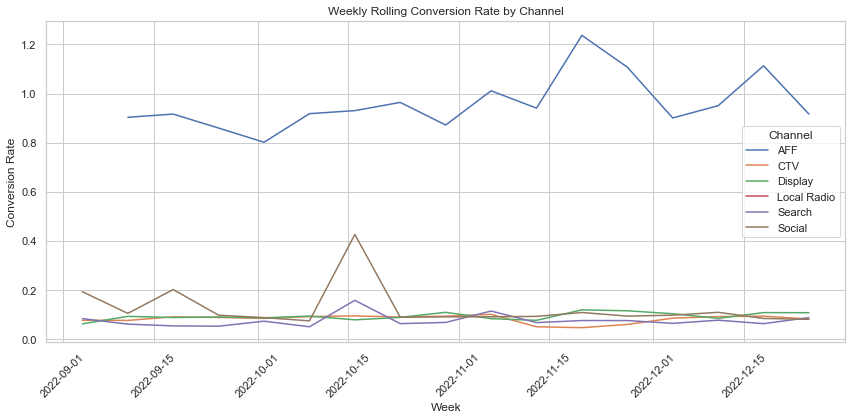

In [51]:
# Set plot style
sns.set(style="whitegrid")

# Weekly rolling cost-effectiveness
plt.figure(figsize=(12,6))
sns.lineplot(data=rolling_metrics['W'], x="Date", y="minutes_per_dollar", hue="Channel")
plt.title("Weekly Rolling Cost-Effectiveness (Minutes per Dollar)")
plt.ylabel("Minutes per Dollar")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekly CAC
plt.figure(figsize=(12,6))
sns.lineplot(data=rolling_metrics['W'], x="Date", y="cac", hue="Channel")
plt.title("Weekly Rolling CAC by Channel")
plt.ylabel("CAC ($ per New Customer)")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Weekly conversion rate
plt.figure(figsize=(12,6))
sns.lineplot(data=rolling_metrics['W'], x="Date", y="conversion_rate", hue="Channel")
plt.title("Weekly Rolling Conversion Rate by Channel")
plt.ylabel("Conversion Rate")
plt.xlabel("Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

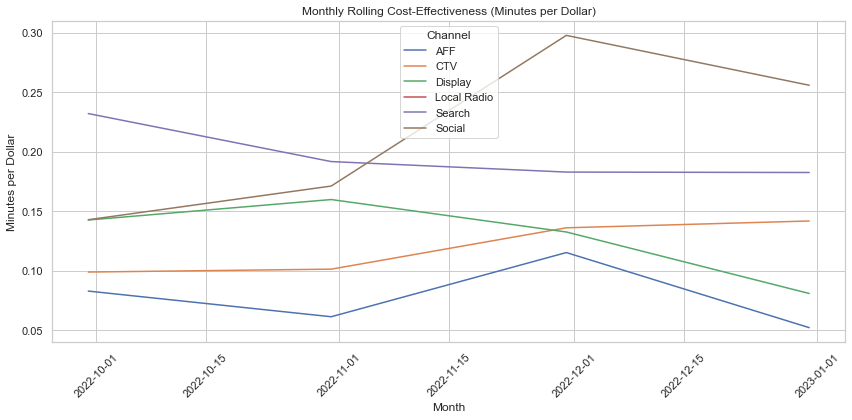

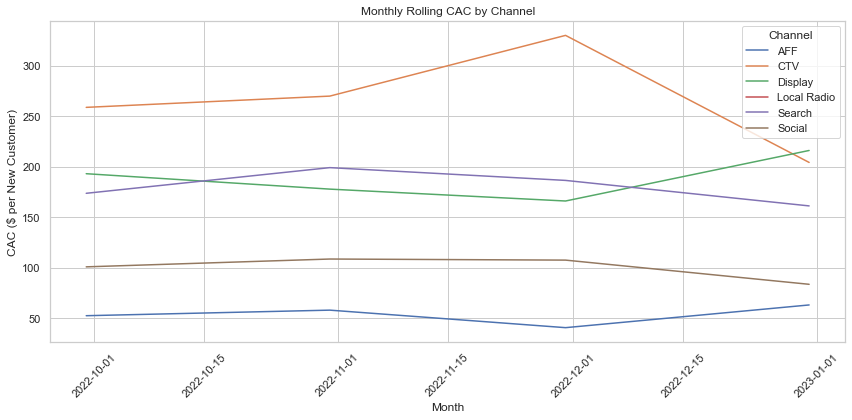

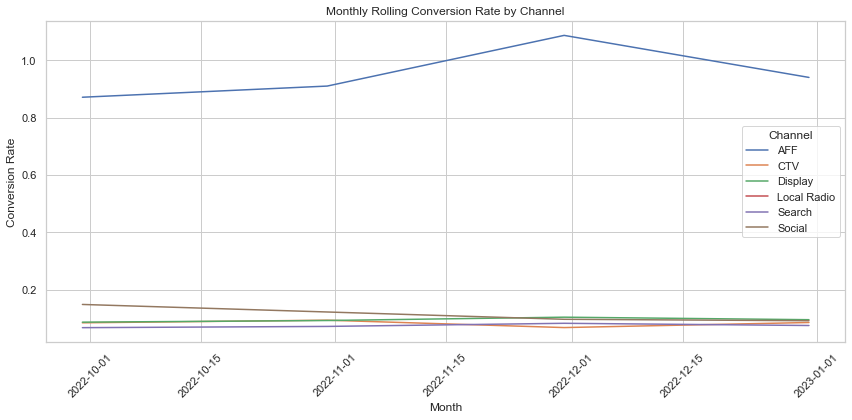

In [52]:
# Set plot style
sns.set(style="whitegrid")

# Monthly rolling cost-effectiveness
plt.figure(figsize=(12,6))
sns.lineplot(data=rolling_metrics['M'], x="Date", y="minutes_per_dollar", hue="Channel")
plt.title("Monthly Rolling Cost-Effectiveness (Minutes per Dollar)")
plt.ylabel("Minutes per Dollar")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly CAC
plt.figure(figsize=(12,6))
sns.lineplot(data=rolling_metrics['M'], x="Date", y="cac", hue="Channel")
plt.title("Monthly Rolling CAC by Channel")
plt.ylabel("CAC ($ per New Customer)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly conversion rate
plt.figure(figsize=(12,6))
sns.lineplot(data=rolling_metrics['M'], x="Date", y="conversion_rate", hue="Channel")
plt.title("Monthly Rolling Conversion Rate by Channel")
plt.ylabel("Conversion Rate")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


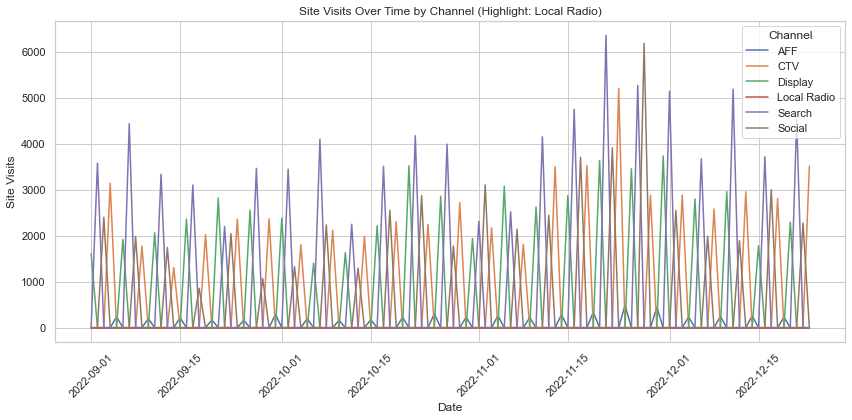

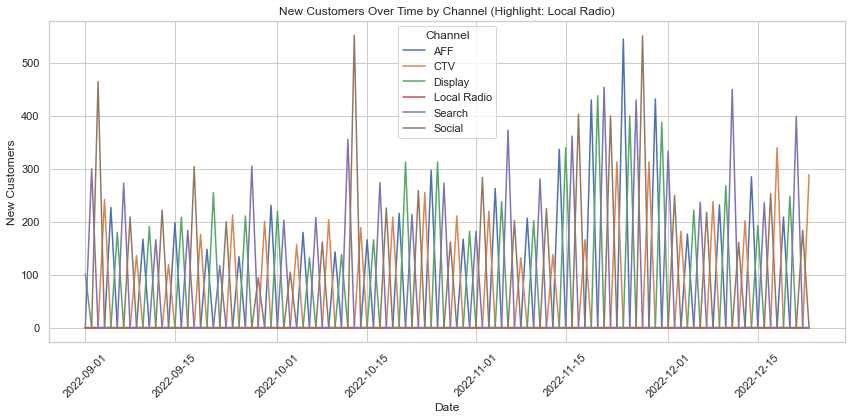

In [53]:
# Visualizing Local Radio Effect

# Aggregate weekly/monthly for visualization
local_radio_df = merged_df.reset_index()
radio_agg = local_radio_df.groupby(["Date", "Channel"]).agg({
    "Spend":"sum",
    "Site_Visits":"sum",
    "New_Customers":"sum"
}).reset_index()

# Plot Site Visits over time for Local Radio vs Others
plt.figure(figsize=(12,6))
sns.lineplot(data=radio_agg, x="Date", y="Site_Visits", hue="Channel")
plt.title("Site Visits Over Time by Channel (Highlight: Local Radio)")
plt.ylabel("Site Visits")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot New Customers (Conversion) over time
plt.figure(figsize=(12,6))
sns.lineplot(data=radio_agg, x="Date", y="New_Customers", hue="Channel")
plt.title("New Customers Over Time by Channel (Highlight: Local Radio)")
plt.ylabel("New Customers")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [54]:
import os
# Set a folder to save all CSVs
output_folder = "/Users/kenny/Documents/IPG_PowerBI_Exports"
os.makedirs(output_folder, exist_ok=True)

# Channel Summary
channel_summary.to_csv(os.path.join(output_folder, "channel_summary.csv"), index=False)

# Weekly Rolling Metrics
rolling_metrics['W'].to_csv(os.path.join(output_folder, "weekly_rolling_metrics.csv"), index=False)

# Monthly Rolling Metrics
rolling_metrics['M'].to_csv(os.path.join(output_folder, "monthly_rolling_metrics.csv"), index=False)

# Daily-Level Data (includes LR activity and traffic)
daily.to_csv(os.path.join(output_folder, "daily_data.csv"), index=False)

# Local Radio only
local_radio_df = merged_df[merged_df["Channel"]=="Local Radio"].reset_index()
local_radio_df.to_csv(os.path.join(output_folder, "local_radio_data.csv"), index=False)

print(f" All CSVs exported to: {output_folder}")


 All CSVs exported to: /Users/kenny/Documents/IPG_PowerBI_Exports
